# Deterministic Renewable Resource Model

**Randall Romero Aguilar, PhD**

This demo is based on the original Matlab demo accompanying the  <a href="https://mitpress.mit.edu/books/applied-computational-economics-and-finance">Computational Economics and Finance</a> 2001 textbook by Mario Miranda and Paul Fackler.

Original (Matlab) CompEcon file: **demdoc04.m**

Running this file requires the Python version of CompEcon. This can be installed with pip by running

    !pip install compecon --upgrade

<i>Last updated: 2021-Oct-01</i>
<hr>

## About

Welfare maximizing social planner must decide the rate at which a renewable resource should be harvested.

* State
  - s     resource stock
* Control
  - q     harvest rate
* Parameters
  - 𝛼     biological growth function scale factor
  - β     biological growth function elasticity
  - κ     harvest unit cost scale factor
  - γ     harvest unit cost elasticity
  - η     inverse elasticity of demand
  - 𝜌     continuous discount rate

## Preliminary tasks

### Import relevant packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from compecon import BasisChebyshev, OCmodel, NLP

### Model parameters

In [2]:
𝛼 = 0.25    # biological growth function scale factor
β = 0.50    # biological growth function elasticity
κ = 5.00    # harvest unit cost scale factor
γ = 1.50    # harvest unit cost elasticity
η = 1.50    # inverse elasticity of demand
𝜌 = 0.05    # continuous discount rate

### Approximation structure

In [3]:
n = 20          # number of basis functions
smin = 0.2        # minimum state
smax = 1.0        # maximum state
basis = BasisChebyshev(n, smin, smax, labels=['q'])  # basis functions

### Steady-state

In [4]:
sstar = 0.6
qstar = 𝛼 * sstar * (1-sstar**β)
xstar = np.array((sstar, qstar))

def funcss(x):
    s, q = x
    p    = q**(-η)                          # inverse demand function
    pder = -η * q**(-η-1)                   # inverse demand derivative
    g    = 𝛼 * s* (1-s**β)                  # biological growth function
    gder = 𝛼 * (1-(1 + β) * s**β)           # marginal biological growth function
    k    = κ * s** (-γ)                     # harvest unit cost function
    kder = -κ * γ * s**(-γ-1)               # harvest unit cost derivative
    return np.array([g-q, ((𝜌 - gder) * (p-k) + kder * g) / pder])

sstar, qstar = NLP(funcss).broyden(xstar)

steadystate = pd.Series([sstar, qstar],
                       index=['Resource stock', 'Rate of harvest'])

steadystate

Resource stock     0.366728
Rate of harvest    0.036161
dtype: float64

## Solve HJB equation by collocation


In [5]:
def control(s, Vs, 𝛼, β, κ, γ, η, 𝜌):
    k = κ * s**(-γ)
    return (Vs + k)**(-1/η)

def reward(s, q, 𝛼, β, κ, γ, η, 𝜌):
    u = (1/(1-η)) * q **(1-η)
    k = κ * s**(-γ)
    return u - k*q

def transition(s, q, 𝛼, β, κ, γ, η, 𝜌):
    g = 𝛼 * s * (1-s**β)
    return g - q

model = OCmodel(basis, control, reward, transition, rho=𝜌, params=[𝛼, β, κ, γ, η, 𝜌])
data = model.solve()

Solving optimal control model
iter change       time    
------------------------------
   0       4.7e+02    0.0020
   1       2.5e+02    0.0030
   2       3.9e+00    0.0030
   3       1.4e-02    0.0030
   4       1.1e-06    0.0040
   5       8.5e-14    0.0050
Elapsed Time =    0.00 Seconds


## Plots

### Optimal policy

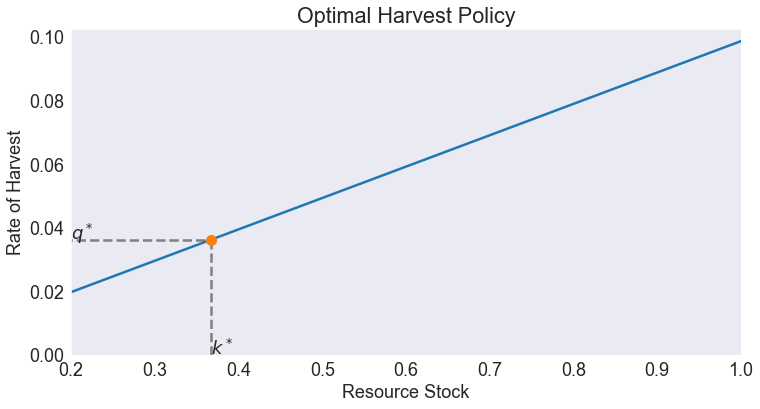

In [6]:
fig, ax = plt.subplots()
data['control'].plot(ax=ax)
ax.set(title='Optimal Harvest Policy',
       xlabel='Resource Stock',
       ylabel='Rate of Harvest',
       xlim=[smin, smax])
ax.set_ylim(bottom=0)
ax.hlines(qstar, 0, sstar, colors=['gray'], linestyles=['--'])
ax.vlines(sstar, 0, qstar, colors=['gray'], linestyles=['--'])
ax.annotate('$q^*$', (smin, qstar))
ax.annotate('$k^*$', (sstar, 0))
ax.plot(sstar, qstar, '.', ms=20);

### Value function

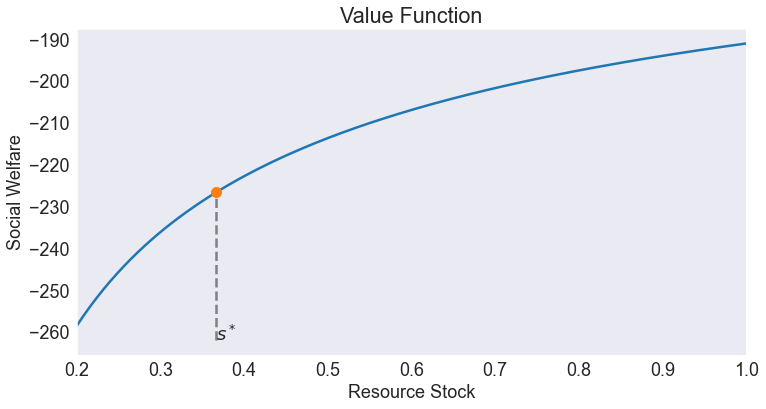

In [7]:
fig, ax = plt.subplots()
data['value'].plot(ax=ax)
ax.set(title='Value Function',
       xlabel='Resource Stock',
       ylabel='Social Welfare',
       xlim=[smin, smax])

lb = ax.get_ylim()[0]
vstar = model.Value(sstar)
ax.vlines(sstar, lb , vstar, colors=['gray'], linestyles=['--'])
ax.annotate('$s^*$', (sstar, lb))
ax.plot(sstar, vstar, '.', ms=20);

### Shadow price

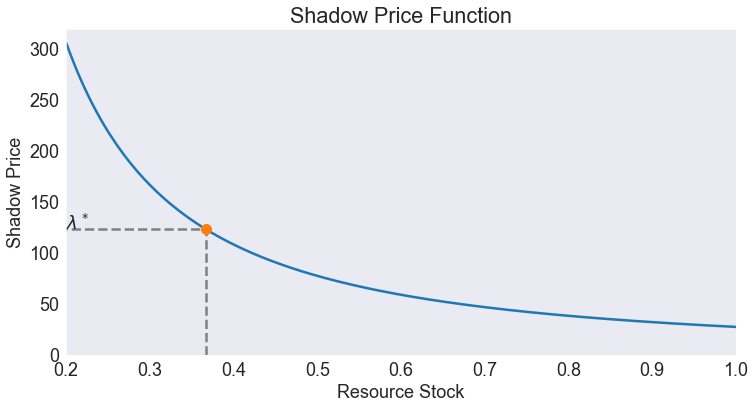

In [8]:
data['shadow'] = model.Value(data.index, 1)

fig, ax = plt.subplots()
data['shadow'].plot(ax=ax)
ax.set(title='Shadow Price Function',
       xlabel='Resource Stock',
       ylabel='Shadow Price',
       xlim=[smin, smax])

pstar = model.Value(sstar, 1)
ax.set_ylim(bottom=0)
ax.hlines(pstar, 0, sstar, colors=['gray'], linestyles=['--'])
ax.vlines(sstar, 0 , pstar, colors=['gray'], linestyles=['--'])
ax.annotate('$\lambda^*$', (smin, pstar))
ax.annotate('$k^*$', (pstar, 0))
ax.plot(sstar, pstar, '.', ms=20);

### Residual

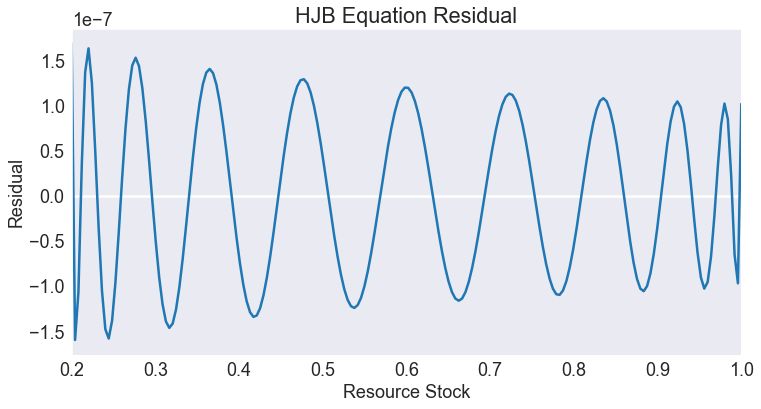

In [9]:
fig, ax = plt.subplots()
ax.axhline(0, c='white')
data['resid'].plot(ax=ax)
ax.set(title='HJB Equation Residual',
       xlabel='Resource Stock',
       ylabel='Residual',
       xlim=[smin, smax]);

## Simulate the model

### Initial state and time horizon

In [10]:
s0 = smax  # initial capital stock
T  = 20    # time horizon

### Simulation and plot

PARAMETER xnames NO LONGER VALID. SET labels= AT OBJECT CREATION


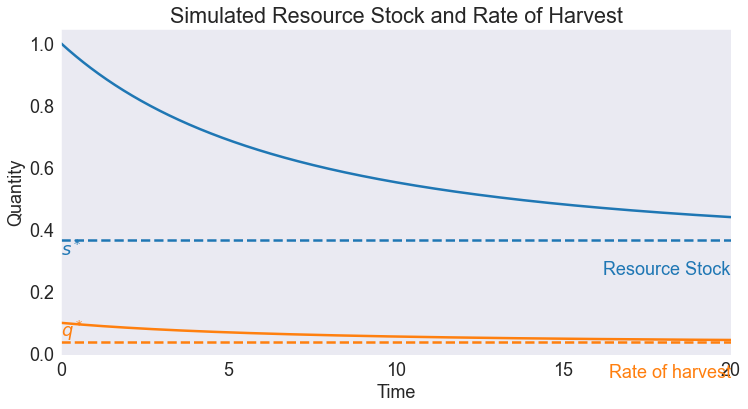

In [11]:
fig, ax = plt.subplots()
model.simulate([s0], T).plot(ax=ax)
ax.set(title='Simulated Resource Stock and Rate of Harvest',
       xlabel='Time',
       ylabel='Quantity',
       xlim=[0, T],
       xticks=np.arange(0,T+1,5))

ax.axhline(sstar, ls='--', c='C0')
ax.axhline(qstar, ls='--', c='C1')

ax.annotate('$s^*$', (0, sstar), color='C0', va='top')
ax.annotate('$q^*$', (0, qstar), color='C1', va='bottom')

ax.annotate('\nResource Stock', (T, sstar), color='C0', ha='right', va='top')
ax.annotate('\nRate of harvest', (T, qstar), color='C1', ha='right', va='top')

ax.legend([]);